In [1]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=64,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=64,shuffle=False)

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

GPU name: NVIDIA GeForce GTX 1660
Using device: cuda


In [12]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size) #(b,p,k,k)

    return kernels

In [13]:
#EncoderIM
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        kernel_in = int(channels*kernel_size**2)

        self.B = nn.Parameter(torch.randn(int(kernel_in/leverage), kernel_in) * (1/np.sqrt(kernel_in)))#.to(device)
        self.B.requires_grad = False

    
    def forward(self, x):
        b, n_patches, k, _ = x.shape
        x = x.view(b*n_patches, -1) 
        x = x.T
        x = torch.matmul(self.B,x)
        x = torch.abs(x)**2
        x = x.T
       
        return x

In [14]:
class MLP(nn.Module):
    def __init__(self,potential_dim):
        super(MLP, self).__init__()
        mid_num = int(potential_dim/2)
        self.fc1 = nn.Linear(potential_dim, mid_num) 
        self.fc2 = nn.Linear(mid_num, 10)
        self.func = nn.Tanh()

    def forward(self, x):
        x = self.func(self.fc1(x))  # 隠れ層
        x = self.fc2(x)  # 出力層
        return x

In [15]:
class EncoderClassifier(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()

        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        
        kernel_in = kernel_size**2
        feat_dim = int(kernel_in/leverage)
        num_patches = (28//kernel_size)*(28//kernel_size)
        potential_dim = num_patches * feat_dim
        self.encoder = Encoder(kernel_size,leverage,channels) 
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        b=x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)  
        x = split_into_kernels(x, self.kernel_size) 
        x = self.encoder(x) 
        x = x.reshape(b, -1)
        x = self.classifier(x)
        return x

1/5th Time Epoch: 10/10

Test Accuracy: 82.62%
loss_train: 0.5439,loss_test: 0.5480
LOSS:0.5480
ProcessingTime: 136.5689513683319


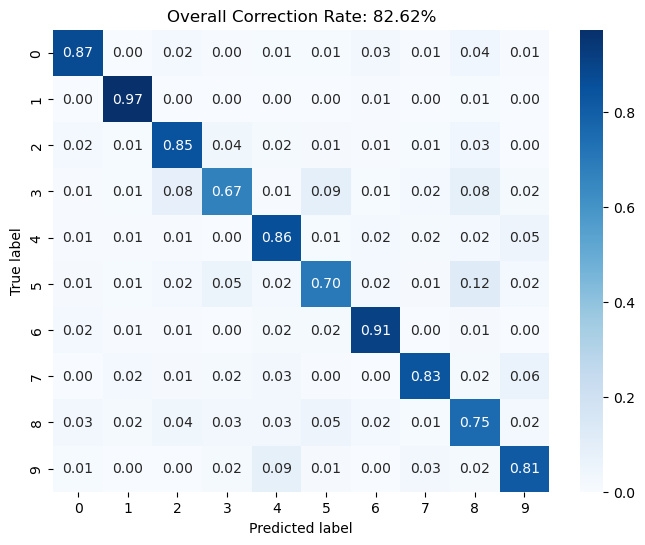

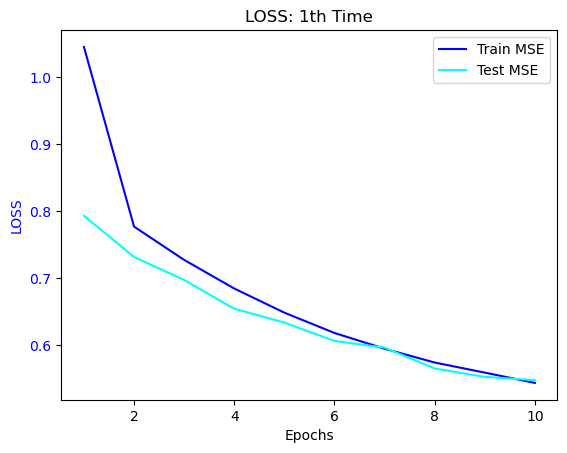

2/5th Time Epoch: 10/10

Test Accuracy: 82.38%
loss_train: 0.5828,loss_test: 0.5681
LOSS:0.5681
ProcessingTime: 137.30461502075195


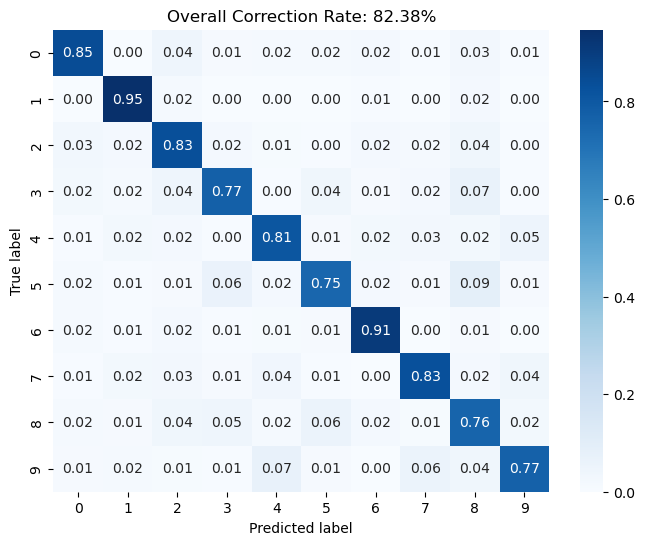

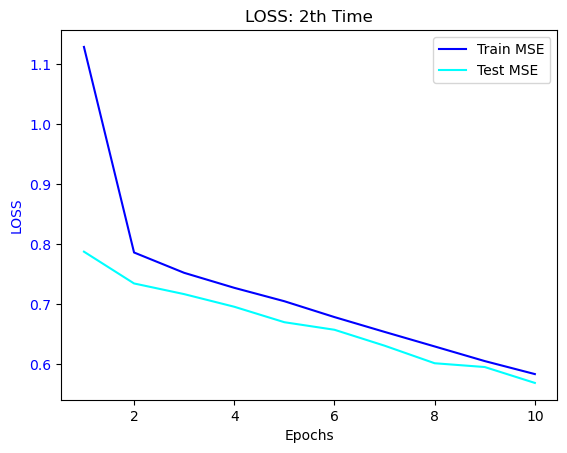

3/5th Time Epoch: 10/10

Test Accuracy: 82.67%
loss_train: 0.5202,loss_test: 0.5356
LOSS:0.5356
ProcessingTime: 133.69641160964966


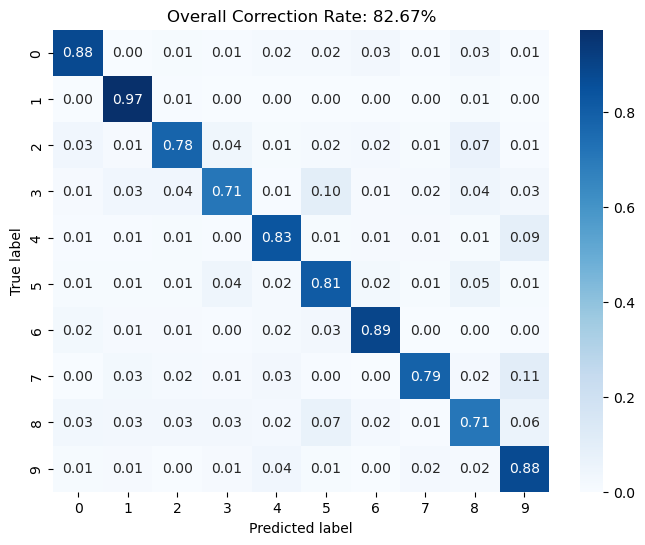

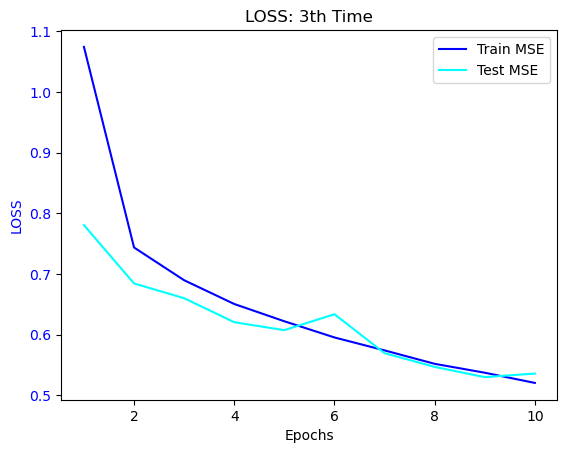

4/5th Time Epoch: 10/10

Test Accuracy: 83.37%
loss_train: 0.5034,loss_test: 0.5137
LOSS:0.5137
ProcessingTime: 128.6342384815216


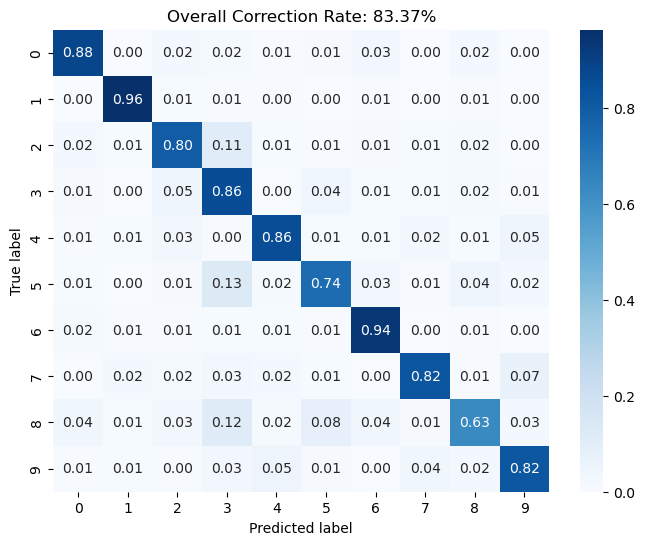

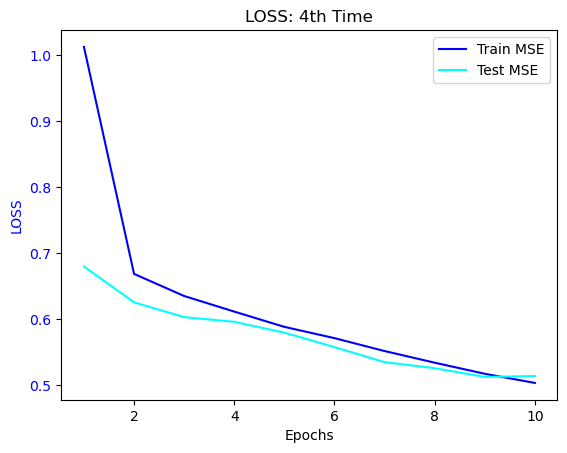

5/5th Time Epoch: 10/10

Test Accuracy: 81.00%
loss_train: 0.5736,loss_test: 0.5720
LOSS:0.5720
ProcessingTime: 127.83247423171997


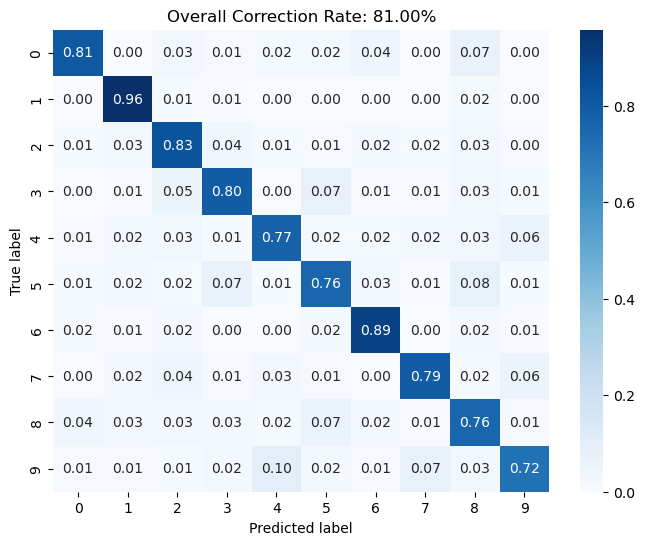

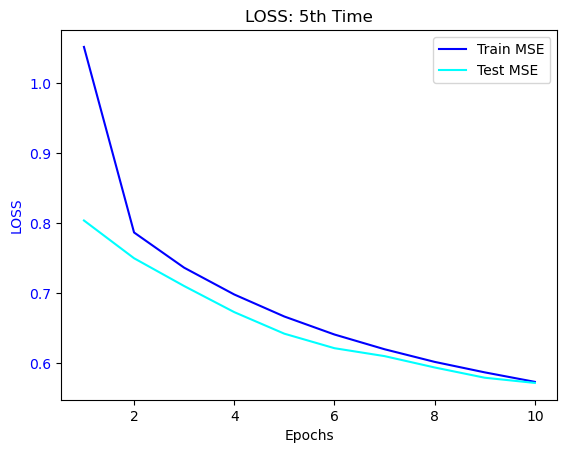

In [16]:
channels = 1
img_size = 28
leverage = 8
kernel_size = 4
max_epochs = 10##10

num_try = 5##5

All_last_loss = []
All_loss_test = []
All_pro_time = []


for num_times in range(num_try): 

    model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            loss = criterion(y, t) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)


        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                _, predicted = torch.max(y, 1)
                loss = criterion(y,t)
                loss_test += loss.item()        
                total += t.size(0)
                correct += (predicted == t).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(t.cpu().numpy())

        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        #if epoch == max_epochs-1:
    All_loss_test.append(loss_test_)
    All_pro_time.append(sum(pro_time_)) 

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print(f"LOSS:{Last_loss_test:.4f}")
    print('ProcessingTime:',sum(pro_time_))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Correction Rate: {100 * correct / total:.2f}%")
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'LOSS: %dth Time'%(num_times+1) #
    plt.title(title)
    plt.show()


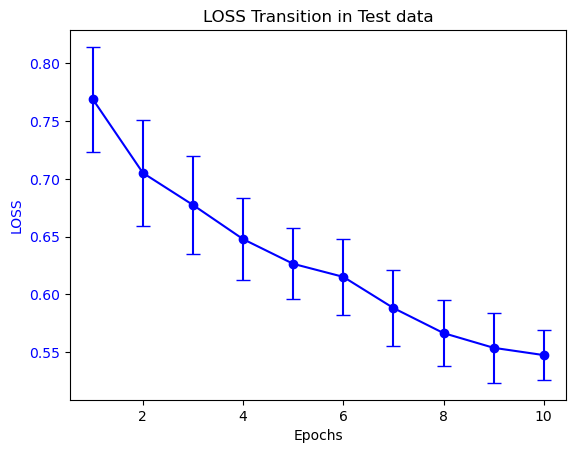

In [17]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('LOSS Transition in Test data')
plt.show()

In [18]:
'''pro_time_mean = sum(All_pro_time)/len(All_pro_time)
data2 = {
    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
    "Processing Time": All_pro_time                # 各処理時間
}

df2 = pd.DataFrame(data2)
df2.loc[""] = ["Average", pro_time_mean]

print(df2)'''

'pro_time_mean = sum(All_pro_time)/len(All_pro_time)\ndata2 = {\n    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）\n    "Processing Time": All_pro_time                # 各処理時間\n}\n\ndf2 = pd.DataFrame(data2)\ndf2.loc[""] = ["Average", pro_time_mean]\n\nprint(df2)'

In [19]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_Classifer\data\texts
